# In this project, I found this data on kaggle and decided to conduct a Sentiment Analysis on reviews. In this I have used Tf-Idf and Bag of words techniques to predict number of stars on basis of the review provided. I have also created word clouds of most positive and most negative words used in reviews. Also performed Stemming, Lemmantization on the reviews to get them in proper format for analysis.

# Stemming,Lemmantization and Sentiment Analysis of Yelp Reviews(Natural Language Processing)

In [1]:
# numerical modules
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
# machine learning modules
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

C:\Users\soham\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# text processing modules
from textblob import TextBlob, Word
from nltk.stem.porter import PorterStemmer

import heapq
from collections import Counter, OrderedDict

In [6]:
# wordcloud visualization
from wordcloud import WordCloud

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999999;

<IPython.core.display.Javascript object>

# 1) Data Loading

In [9]:
#Loading the csv file
yelp_df = pd.read_csv('review.csv')

In [10]:
yelp_df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [11]:
yelp_df.shape

(10000, 10)

In [13]:
yelp_df['type'].unique()

array(['review'], dtype=object)

In [14]:
# business_id, date, user_id, type columns are irrelevant for now
yelp_df.drop(['business_id', 'date', 'review_id', 'type', 'user_id'], axis=1, inplace=True)

In [15]:
yelp_df.head()

,stars,text,cool,useful,funny
0,5,My wife took me here on my birthday for breakf...,2,5,0
1,5,I have no idea why some people give bad review...,0,0,0
2,4,love the gyro plate. Rice is so good and I als...,0,1,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0


# Now We Will only keep the most positive and most negative reviews 

In [16]:
# Here we used the And function to only select positive and negative reviews i.e. reviews having 1 and 5 stars only
yelp_df = yelp_df[(yelp_df['stars'] == 5) | (yelp_df['stars'] == 1)]

In [18]:
# Here is the text of first 5 positive reviews 
yelp_df[yelp_df['stars']==5]['text'].head()

0    My wife took me here on my birthday for breakf...
1    I have no idea why some people give bad review...
3    Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4    General Manager Scott Petello is a good egg!!!...
6    Drop what you're doing and drive here. After I...
Name: text, dtype: object

In [19]:
# similarly here is few of negative reviews
yelp_df[yelp_df['stars']==1]['text'].head()

23    U can go there n check the car out. If u wanna...
31    Disgusting!  Had a Groupon so my daughter and ...
35    I've eaten here many times, but none as bad as...
61    I have always been a fan of Burlington's deals...
64    Another night meeting friends here.  I have to...
Name: text, dtype: object

So, we can see infer from the above texts that some of reviews are bad and some are good

In [21]:
# Checking how many are positive sentiment and how many are negative
yelp_df['stars'].value_counts()

5    3337
1     749
Name: stars, dtype: int64

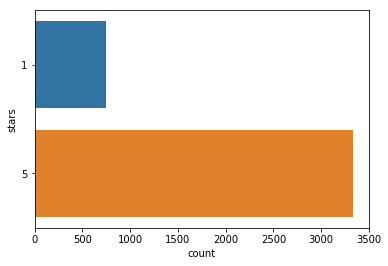

In [23]:
# This shows graph what we found above graphically
sns.countplot(y='stars', data=yelp_df)


In [24]:
ratio = float(len(yelp_df[yelp_df['stars'] == 5])) / (len(yelp_df[yelp_df['stars'] == 5]) + len(yelp_df[yelp_df['stars'] == 1]))

In [25]:
print("Null Accuracy: %0.6f" % (ratio))

Null Accuracy: 0.816691


# 2. Sentiment Analysis with TextBlob

In [26]:
# print the first yelp review
print(yelp_df.text[0])

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!


In [28]:
yelp_df.stars[0]

5

In [29]:
# polarity ranges from -1 (most negative) to 1 (most positive)# polari 
review = TextBlob(yelp_review_df.text[0])

In [31]:
review.sentiment.polarity

0.40246913580246907

In [32]:
review.sentiment.subjectivity

0.6591122868900646

In [39]:
# create a new DataFrame column for sentiment# create 
yelp_df['texblob_sentiment_score'] = yelp_df.text.apply(lambda x :TextBlob(x).sentiment.polarity)

In [40]:
yelp_df.head()

,stars,text,cool,useful,funny,texblob_sentiment_score
0,5,My wife took me here on my birthday for breakf...,2,5,0,0.402469
1,5,I have no idea why some people give bad review...,0,0,0,0.229773
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,0.608646
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0,0.468125
6,5,Drop what you're doing and drive here. After I...,7,7,4,0.300645


In [42]:
# let's look at some negative reviews
yelp_df[yelp_df['stars'] == 1].head(10)

,stars,text,cool,useful,funny,texblob_sentiment_score
23,1,U can go there n check the car out. If u wanna...,0,1,1,-0.264021
31,1,Disgusting! Had a Groupon so my daughter and ...,0,1,0,-0.099091
35,1,"I've eaten here many times, but none as bad as...",0,4,3,-0.035973
61,1,I have always been a fan of Burlington's deals...,0,0,0,-0.015278
64,1,Another night meeting friends here. I have to...,0,1,2,-0.063456
65,1,Not busy at all but took nearly 45 min to get ...,0,1,0,0.016667
71,1,"Yikes, reading other reviews I realize my bad ...",0,6,1,-0.009365
79,1,This is my first year participating in Arizona...,0,0,0,0.054167
84,1,"really, I can't believe this place has receive...",1,1,3,0.130092
89,1,"I was really excited about this event, maybe m...",0,1,0,0.192386


In [44]:
# let's check a random negative review, 35 seems to tbe good candidate
print(yelp_review_df.text[35])

I've eaten here many times, but none as bad as last night.
Service was excellent, and highly attentive.
Food, absolutely horrible.

My expectation was they would serve a steak on par with their seafood. After all, they were charging 39 bucks for a ribeye. 
What I was hoping for was a 1- 1-1/2' thick steak, cooked Pittsburgh style as I had ordered. 
What I got a a 3/4 in thick piece of meat that was mostly fat, gristle, and in no way resembled Pittsburgh Style. 
Salad, similar to something you could get at Chick Filet
Veggies, blah.
Bread basket, ample, but day old, and if not, it certainly wasn't fresh. 

In addition to bad food, we were crammed into a small room where we were nuts to butts with 6 other tables, listening to conversations ranging from someone's recent bout with pinkeye, and another couple who elected to speak entirely in French, until the waiter showed up, then it was like they turned off the French switch and suddenly began speaking English. 

I've had it with this pla

In [46]:
# let's look at some positive reviews
yelp_df[yelp_df['stars'] == 5].head(10)

,stars,text,cool,useful,funny,texblob_sentiment_score
0,5,My wife took me here on my birthday for breakf...,2,5,0,0.402469
1,5,I have no idea why some people give bad review...,0,0,0,0.229773
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,0.608646
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0,0.468125
6,5,Drop what you're doing and drive here. After I...,7,7,4,0.300645
9,5,Nobuo shows his unique talents with everything...,0,1,0,0.158333
10,5,The oldish man who owns the store is as sweet ...,1,3,1,0.326389
11,5,Wonderful Vietnamese sandwich shoppe. Their ba...,1,1,0,0.608333
12,5,They have a limited time thing going on right ...,1,2,0,0.153022
17,5,okay this is the best place EVER! i grew up sh...,0,0,0,0.570635


In [48]:
# let's check a random predicted positive review, 9 seems to tbe good candidate
print(yelp_review_df.text[9])

Nobuo shows his unique talents with everything on the menu. Carefully crafted features with much to drink. Start with the pork belly buns and a stout. Then go on until you can no longer.


In [50]:
# reviews with most positive sentiment
yelp_df[yelp_df['texblob_sentiment_score'] == 1]['text'].head()

254    Our server Gary was awesome. Food was amazing....
347    3 syllables for this place. \nA-MAZ-ING!\n\nTh...
420                                    LOVE the food!!!!
459    Love it!!! Wish we still lived in Arizona as C...
679                                     Excellent burger
Name: text, dtype: object

In [51]:
# reviews with most negative sentiment
yelp_df[yelp_df['texblob_sentiment_score'] == -1]['text'].head()

773     This was absolutely horrible. I got the suprem...
1517                  Nasty workers and over priced trash
3266    Absolutely awful... these guys have NO idea wh...
4766                                       Very bad food!
5812        I wouldn't send my worst enemy to this place.
Name: text, dtype: object

In [53]:
# what is the minimum sentiment given by textblob for negative reviews?
yelp_df[yelp_df['stars'] == 1]['texblob_sentiment_score'].min()

-1.0

In [55]:
# what is the maximum sentiment given by textblob for negative reviews?
yelp_df[yelp_df['stars'] == 1]['texblob_sentiment_score'].max()

1.0

In [58]:
# positive sentiment in a 1-star review
yelp_df[(yelp_df['stars'] == 1) & (yelp_df['texblob_sentiment_score'] > 0.7)]

,stars,text,cool,useful,funny,texblob_sentiment_score
1781,1,If you like the stuck up Scottsdale vibe this ...,0,1,2,0.766667
6222,1,"My mother always told me, if I didn't have any...",1,2,1,0.750000
8833,1,The owner has changed hands & this place isn't...,0,1,0,1.000000


In [61]:
print(yelp_review_df.text[8833])

The owner has changed hands & this place isn't what it used to be.  If you want up to date paper & quality product...go to Scrap Happy OR Crop Girls!


In [63]:
# what is the minimum sentiment given by textblob for positive reviews?
yelp_df[yelp_df['stars'] == 5]['texblob_sentiment_score'].min()


-0.625

In [64]:
# what is the maximum sentiment given by textblob for positive reviews?
yelp_df[yelp_df['stars'] == 5]['texblob_sentiment_score'].max()


1.0

In [66]:
# negative sentiment in a 5-star review# negati 
yelp_df[(yelp_df['stars'] == 5) & (yelp_df['texblob_sentiment_score'] < -0.3)]

,stars,text,cool,useful,funny,texblob_sentiment_score
390,5,RIP AZ Coffee Connection. :( I stopped by tw...,1,0,0,-0.302083
1287,5,"Obsessed. Like, I've-got-the-Twangy-Tart-withd...",3,3,5,-0.625000
3075,5,Unfortunately Out of Business.,0,2,0,-0.500000
3516,5,"Cashew brittle, almond brittle, bacon brittle!...",9,8,6,-0.375000
6726,5,"Brown bag chicken sammich, mac n cheese, fried...",0,0,0,-0.600000
9809,5,I have to tell you....\n\nI had their Jerk Chi...,1,1,1,-0.397656


In [72]:
print(yelp_review_df['text'][9809])

I have to tell you....

I had their Jerk Chicken Plate the other night, and it was yuuuuummmmmyyy! You gotta try it!


# Use TextBlob to calculate stars for the reviews

In [73]:
yelp_df['textblob_predicted_stars'] = yelp_df['texblob_sentiment_score'].apply(lambda x : 5 if x > 0.1 else 1)

In [74]:
yelp_df.head()

,stars,text,cool,useful,funny,texblob_sentiment_score,textblob_predicted_stars
0,5,My wife took me here on my birthday for breakf...,2,5,0,0.402469,5
1,5,I have no idea why some people give bad review...,0,0,0,0.229773,5
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,0.608646,5
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0,0.468125,5
6,5,Drop what you're doing and drive here. After I...,7,7,4,0.300645,5


In [75]:
print('Textblob Accuracy', metrics.accuracy_score(yelp_df['stars'], yelp_df['textblob_predicted_stars']))

Textblob Accuracy 0.8935389133627019


So we where able to predict upto 90% of correct rating stars on basis of the reviews

# 3. Sentiment Classification with Logistic Regression

## 3.1 Tokenization, Stemming & Lemmatization

After tokenizning the string into words, we use nltk PorterStemmer to stem the tokens.

In [76]:
import re, nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [77]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

english_stops = stopwords.words('english')

In [78]:
print(english_stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [79]:
def simple_tokenizer(text):
    # remove non letters
    text = res.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)    
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
   
    return tokens

In [80]:
def stem_tokenizer(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
    # stem
    stems = []
    for item in tokens:
        stems.append(stemmer.stem(item))
   
    return stems

In [81]:
def lemma_tokenizer(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
    # lemmas
    lemmas = []
    for item in tokens:
        lemmas.append(lemmatizer.lemmatize(item))
        
    return lemmas

Bag Of Words Model

Here we will be using here is called a bag-of-words model. In this kind of model we simplify documents to a multi-set of terms frequencies. That means that, for our model, a document sentiment tag will depend on what words appear in that document, discarding any grammar or word order but keeping multiplicity.



### 3.2.1 Counting Word Frequency

In [82]:
count_vect = CountVectorizer(analyzer = 'word', tokenizer=simple_tokenizer, lowercase=True)

In [88]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [89]:
review_tf = count_vect.fit_transform(yelp_df['text'])

In [90]:
# Numpy arrays are easy to work with, so convert the result to an array
review_tf_nd = review_tf.toarray()
review_tf_nd.shape

(4086, 18443)

In [91]:
# Take a look at how the Document Term Matrix looks
df = pd.DataFrame(review_tf_nd, columns=count_vect.get_feature_names())
df.head(5)

,aaa,aaaamazing,aaammmazzing,aaron,aback,abandoned,abandoning,abba,abbreviate,abbreviated,...,zuccini,zuchinni,zumba,zupa,zupas,zuzu,zuzus,zwftv,zwiebel,zzed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
# let's look at the words in the vocabulary, first 100 and last 100
vocab = count_vect.get_feature_names()
print(vocab[:100]) # First 100 words
print(vocab[-100:]) # Last 100 words
#print(vocab)  # all 18k words

['aaa', 'aaaamazing', 'aaammmazzing', 'aaron', 'aback', 'abandoned', 'abandoning', 'abba', 'abbreviate', 'abbreviated', 'abby', 'abc', 'abdomen', 'abhor', 'abiding', 'abilities', 'ability', 'abilty', 'able', 'abodoba', 'abou', 'abound', 'abrasion', 'abroad', 'abrupt', 'absence', 'absent', 'absinthe', 'absoloutely', 'absolut', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absorb', 'absorption', 'abstain', 'abstained', 'abstract', 'absurd', 'abuelo', 'abundance', 'abundant', 'abuse', 'abused', 'abusive', 'abysmal', 'acacia', 'academy', 'acai', 'acapulco', 'accent', 'accented', 'accents', 'accept', 'acceptable', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accessible', 'accessories', 'accessorize', 'accessory', 'accident', 'accidental', 'accidentally', 'accidently', 'acclaimed', 'accolades', 'accommodate', 'accommodated', 'accommodates', 'accommodating', 'accommodation', 'accommodations', 'accomodate', 'accomodated', 'accomodating', 'accompanied', 'accompanies', 'acc

In [94]:
# calculate frequency distribution of words in positive reviews
dist = np.sum(review_tf_nd[np.where(yelp_df['stars'] == 5)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count

In [132]:
# word_count sum sorted by value
counter.most_common(20)


[('great', 2011),
 ('place', 1988),
 ('food', 1679),
 ('good', 1663),
 ('like', 1278),
 ('one', 1254),
 ('get', 1108),
 ('love', 1104),
 ('time', 1063),
 ('best', 970),
 ('service', 901),
 ('really', 879),
 ('always', 846),
 ('also', 841),
 ('back', 767),
 ('would', 717),
 ('well', 689),
 ('amazing', 618),
 ('delicious', 579),
 ('nice', 578)]

In [133]:
dicttt={'great': 2011, 'place': 1988, 'food': 1679, 'good': 1663, 'like': 1278, 'one': 1254, 'get': 1108, 'love': 1104, 'time': 1063, 'best': 970, 'service': 901, 'really': 879, 'always': 846, 'also': 841, 'back': 767, 'would': 717, 'well': 689, 'amazing': 618, 'delicious': 579, 'nice': 578}

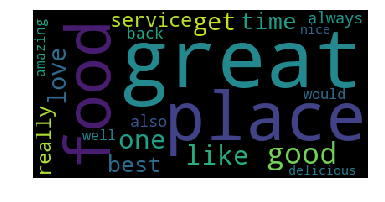

In [135]:

wordcloud = WordCloud().fit_words(dicttt)
plt.axis("off")
plt.imshow(wordcloud)

In [137]:
# calculate frequency distribution of words in negative reviews
dist = np.sum(review_tf_nd[np.where(yelp_df['stars'] == 1)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count

In [138]:
# word_count sum sorted by value
counter.most_common(20)

[('food', 586),
 ('place', 489),
 ('like', 439),
 ('one', 407),
 ('get', 361),
 ('would', 331),
 ('service', 325),
 ('back', 320),
 ('good', 301),
 ('time', 301),
 ('even', 278),
 ('never', 241),
 ('minutes', 218),
 ('order', 206),
 ('got', 205),
 ('ordered', 202),
 ('really', 194),
 ('went', 192),
 ('said', 187),
 ('restaurant', 185)]

In [143]:
dictt2={'food': 586,'place':489,'like': 439,'one': 407,'get': 361,'would':331,'service': 325,'back': 320,'good': 301,
 'time':301,
 'even': 278,
 'never': 241,
 'minutes': 218,
 'order': 206,
 'got': 205,
 'ordered': 202,
 'really': 194,
'went': 192,
 'said': 187,
 'restaurant': 185}

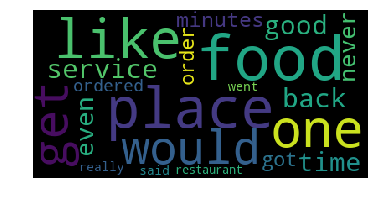

In [144]:
wordcloud = WordCloud().fit_words(dictt2)
plt.axis("off")
plt.imshow(wordcloud)

### 3.2.3 Predict the stars rating - A bag-of-words Linear Classifier

In [146]:
# split Train and Validation Data Set
X_train, X_test, y_train, y_test  = train_test_split(review_tf_nd, yelp_df['stars'], train_size=0.75)

In [147]:
# Create and train the Logistic Regression Classifier
log_tf_model = LogisticRegression()
log_tf_model = log_tf_model.fit(X=X_train, y=y_train)

In [148]:
# Use the classifier to label our evaluation set. We can use either predict for classes or predict_proba for probabilities.
y_pred = log_tf_model.predict(X=X_test)
y_pred_proba = log_tf_model.predict_proba(X=X_test)[:,1]

In [149]:
#calculates several types of (predictive) scores on a classification model
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.91      0.69      0.79       179
          5       0.94      0.99      0.96       843

avg / total       0.93      0.93      0.93      1022



In [159]:
print("accuracy:  %0.6f"% metrics.accuracy_score(y_test, y_pred))

accuracy:  0.934442


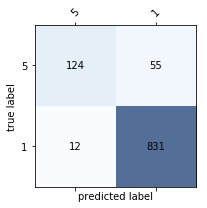

In [160]:
from pylab import rcParams
labels = ['5', '1']
confmat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.7)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks,labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()

In [161]:
fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test, y_pred_proba, pos_label=5)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)

# 3.3 TF-IDF Model

## 3.3.1 Calculate Inverse Document Term Frequency

In [162]:
tfidf_vect = TfidfVectorizer(analyzer = 'word', tokenizer=lemma_tokenizer, lowercase=True)

In [165]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [166]:
review_tf = tfidf_vect.fit_transform(yelp_df.text)

In [167]:
# Numpy arrays are easy to work with, so convert the result to an array# Numpy  
review_tf_nd = review_tf.toarray()
review_tf_nd.shape

(4086, 16337)

In [168]:
# Take a look at how the Document Term Matrix looks
df = pd.DataFrame(review_tf_nd, columns=tfidf_vect.get_feature_names())
df.head(10)

,aaa,aaaamazing,aaammmazzing,aaron,aback,abandoned,abandoning,abba,abbreviate,abbreviated,...,zuccini,zuchinni,zumba,zupa,zupas,zuzu,zuzus,zwftv,zwiebel,zzed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
# let's look at the words in the vocabulary, first 100 and last 100
vocab = tfidf_vect.get_feature_names()
print(vocab[:100]) # First 100 words
print(vocab[-100:]) # Last 100 words
#print(vocab)  # all 18k words

['aaa', 'aaaamazing', 'aaammmazzing', 'aaron', 'aback', 'abandoned', 'abandoning', 'abba', 'abbreviate', 'abbreviated', 'abby', 'abc', 'abdomen', 'abhor', 'abiding', 'ability', 'abilty', 'able', 'abodoba', 'abou', 'abound', 'abrasion', 'abroad', 'abrupt', 'absence', 'absent', 'absinthe', 'absoloutely', 'absolut', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absorb', 'absorption', 'abstain', 'abstained', 'abstract', 'absurd', 'abuelo', 'abundance', 'abundant', 'abuse', 'abused', 'abusive', 'abysmal', 'acacia', 'academy', 'acai', 'acapulco', 'accent', 'accented', 'accept', 'acceptable', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accessible', 'accessorize', 'accessory', 'accident', 'accidental', 'accidentally', 'accidently', 'acclaimed', 'accolade', 'accommodate', 'accommodated', 'accommodates', 'accommodating', 'accommodation', 'accomodate', 'accomodated', 'accomodating', 'accompanied', 'accompanies', 'accompaniment', 'accompany', 'accompanying', 'accomplish', 'a

In [172]:
# calculate frequency distribution of words in positive reviews
dist = np.sum(review_tf_nd[np.where(yelp_df['stars'] == 5)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count
    

In [173]:
counter.most_common(20)

[('great', 131.03597041898036),
 ('place', 113.05547307078189),
 ('food', 102.21339366444383),
 ('good', 93.68256495294435),
 ('love', 91.23321334839521),
 ('best', 74.82220932390386),
 ('time', 72.77568672447293),
 ('service', 67.43993748869981),
 ('always', 65.72706284787824),
 ('one', 64.33464059443395),
 ('get', 62.39477801529317),
 ('like', 60.71231744846042),
 ('amazing', 51.88201697906908),
 ('really', 51.64007315200254),
 ('friendly', 50.56508924263671),
 ('delicious', 50.047550206690346),
 ('also', 48.85090962336725),
 ('staff', 47.197221854488994),
 ('back', 46.30183075093126),
 ('pizza', 45.17805934866678)]

In [176]:
d ={'great':131.03597041898036,
 'place': 113.05547307078189,
'food': 102.21339366444383,
 'good': 93.68256495294435,
 'love': 91.23321334839521,
 'best': 74.82220932390386,
 'time': 72.77568672447293,
'service': 67.43993748869981,
 'always': 65.72706284787824,
 'one': 64.33464059443395,
 'get': 62.39477801529317,
 'like': 60.71231744846042,
 'amazing': 51.88201697906908,
  'really': 51.64007315200254,
 
     'friendly': 50.56508924263671,
 'delicious': 50.047550206690346,
 'also': 48.85090962336725,
 'staff': 47.197221854488994,
 'back': 46.30183075093126,
 'pizza': 45.17805934866678}

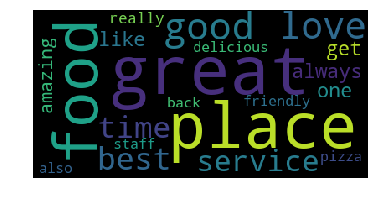

In [177]:
wordcloud = WordCloud().fit_words(d)
plt.axis("off")
plt.imshow(wordcloud)

In [179]:
# calculate frequency distribution of words in negative reviews
dist = np.sum(review_tf_nd[np.where(yelp_df['stars'] == 1)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count
    

In [181]:
counter.most_common(20)

[('food', 27.413376715920993),
 ('place', 21.020716023812756),
 ('service', 19.19022599799789),
 ('like', 18.700208054365056),
 ('time', 17.19917295246528),
 ('one', 16.521516808044964),
 ('get', 15.69508701284176),
 ('back', 15.628870302002532),
 ('would', 15.558851868933054),
 ('minute', 14.783391134762052),
 ('bad', 14.585656469358277),
 ('never', 14.217830698718352),
 ('even', 13.99430547215625),
 ('good', 13.370943161933187),
 ('horrible', 12.458647900787206),
 ('ordered', 12.313456479282019),
 ('order', 12.164459042667001),
 ('told', 11.916779912824232),
 ('customer', 11.914305719747084),
 ('table', 11.759847045295585)]

In [182]:
d2 = {'food': 27.413376715920993, 'place': 21.020716023812756, 'service': 19.19022599799789, 'like': 18.700208054365056, 'time': 17.19917295246528, 'one': 16.521516808044964, 'get': 15.69508701284176, 'back': 15.628870302002532, 'would': 15.558851868933054, 'minute': 14.783391134762052, 'bad': 14.585656469358277, 'never': 14.217830698718352, 'even': 13.99430547215625, 'good': 13.370943161933187, 'horrible': 12.458647900787206, 'ordered': 12.313456479282019, 'order': 12.164459042667001, 'told': 11.916779912824232, 'customer': 11.914305719747084, 'table': 11.759847045295585}

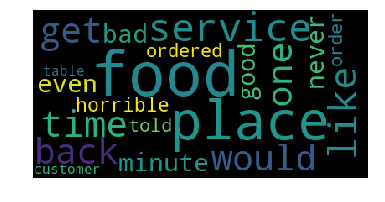

In [183]:
wordcloud = WordCloud().fit_words(d2)
plt.axis("off")
plt.imshow(wordcloud)

In [185]:
# split Train and Validation Data Set
X_train, X_test, y_train, y_test  = train_test_split(review_tf_nd, yelp_df['stars'], train_size=0.75)

In [186]:
from sklearn.linear_model import LogisticRegression
# Create and train the Logistic Regression Classifier
log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train, y=y_train)

In [187]:
# Use the classifier to label our evaluation set. We can use either predict for classes or predict_proba for probabilities.
y_pred = log_tfidf_model.predict(X=X_test)
y_pred_prob = log_tfidf_model.predict_proba(X=X_test)[:,1]

In [188]:
# compute precision and recall, or their combination (harmonic mean) F1:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       1.00      0.29      0.45       178
          5       0.87      1.00      0.93       844

avg / total       0.89      0.88      0.85      1022



In [189]:
print("accuracy: %0.6f" % metrics.accuracy_score(y_test, y_pred))

accuracy: 0.875734


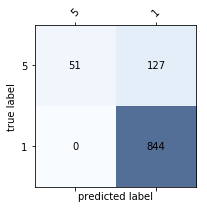

In [190]:
from pylab import rcParams
labels = ['5', '1']
confmat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.7)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks,labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()

### 3.4 Comparing the the Bag-Of-Words and TF-IDF Models with each other

In [192]:
fpr_tfidf, tpr_tfidf, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=5)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)

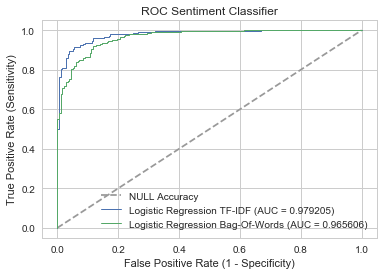

In [193]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression Bag-Of-Words (AUC = %0.6f)' % roc_auc_tf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
